In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs

In [62]:
df = pd.read_excel('Excel/Circuitos_Elec.xlsx')
lista_horarios = list()

In [63]:
horarios_llenos = True #Indica si los horarios se requieren con todas las materias

In [64]:
materias = len(df.Clave.unique())
#materias

In [65]:
def noHaySolape(horario,check):     #horario es el horario que se esta armando. check el renglón que se está checando
    for i in range(0,len(horario)): #Checa con todas las materias
        v = horario.iloc[i,9:15] * check.iloc[9:15] #Checa el vector de días de la semana y los multiplica dia a dia
        if not v.equals(cero): #Si entra al if, significa que comparten algún día
            if not haySolapeHoras(horario.iloc[i],check): 
                return False
        if(horario.iloc[i].Clave == check.Clave): #Si tienen la misma clave, entonces son la misma materia, por lo que se descarta
            return False
    return True



In [66]:
#Verificación por horario
def haySolapeHoras(a,b): #DataFrame, comparativa a comparativa b
    if b.Inicio_min - a.Inicio_min == 0:
        return False
    if b.Inicio_min - a.Inicio_min > 0:
        if(b.Inicio_min - a.Inicio_min >= a.Duracion*60):
            return True
        else:
            return False
    else:
        if(abs(b.Inicio_min - a.Inicio_min) >= b.Duracion*60):
            return True
        else:
            return False    
    

# Get dummies de los días

In [67]:
orden = list(['Lun','Mar','Mie','Jue','Vie','Sab'])
dias = pd.Series(df.Días).str.get_dummies(sep = ', ')
orden = list(['Lun','Mar','Mie','Jue','Vie','Sab'])
dias[orden] = 0
dias = dias[orden]
dias += pd.Series(df.Días).str.get_dummies(sep = ', ')
dias.fillna(0,inplace=True,downcast = 'int64')
#dias

In [68]:
df = pd.concat([df,dias],axis=1)
#df

# Get dummies de las horas

In [69]:
horas = df.Horario.str.split(" a ")

In [70]:
horas = pd.DataFrame.from_dict(dict(zip(horas.index, horas.values))).transpose()
horas.columns = ['Inicio','Fin']
#horas

In [71]:
df = pd.concat([df,horas],axis=1)

In [72]:
hrs_y_min = df.Inicio.str.split(":")
hrs_y_min.str[0]
minutos = hrs_y_min.str[0].astype(int)*60 +  hrs_y_min.str[1].astype(int)
minutos
df = df.assign(Inicio_min = minutos)

hrs_y_min = df.Fin.str.split(":")
hrs_y_min.str[0]
minutos = hrs_y_min.str[0].astype(int)*60 +  hrs_y_min.str[1].astype(int)
minutos
df = df.assign(Fin_min = minutos)
df

duracion = df.Fin_min - df.Inicio_min
df = df.assign(Duracion = duracion/60)
#df

In [73]:
def generarHorarios():
    n=0
    while(df.iloc[n].Clave == df.Clave.unique()[0]):
        horario = pd.DataFrame(columns = df.columns) #crea un df con las mismas columnas para ir armando el horario
        combinarMaterias(df,horario,n)
        n = n+1

In [74]:
def combinarMaterias(df,horario,renglon_actual):
    if renglon_actual < len(df):
        new_row = df.copy()[df.index == renglon_actual]
        horario = pd.concat([horario, new_row])
        for i in range(renglon_actual,len(df)):
            if df.iloc[renglon_actual].Clave == df.iloc[i].Clave: #No compara consigo mismo
                continue
            if noHaySolape(horario,df.iloc[i]):
                combinarMaterias(df,horario,i) #Al ser recursiva, va concatenando las filas del excel que no se solapen y sean diferentes materias
        if((not horarios_llenos) or len(horario)== materias): #Comprueba la variable horarios llenos para ver si tiene que cumplir con cubrir todas las materias del excel.
            lista_horarios.append(horario)
       

In [75]:
def plotMateria(df,gnt):
    import random
    R = random.uniform(0.3,0.75)
    G = random.uniform(0, 0.1)
    B = random.uniform(0.6, 1)
    
    i = 0
    hora = (df.Inicio_min/60)
    duracion = df.Duracion
    
    for cat in df.iloc[9:15]: #Lo que hace es particionar el df a los días de la semana
        if cat == 1:
            gnt.broken_barh([(i,1)], (hora, duracion) ,facecolors = (R, G, B))
            nombre_materia = df.Nombre[:10]                                                     #Corta el texto para que quepa en el cuadro
            nombre = nombre_materia + "\n" + str(df.Gpo)                                       
            gnt.text(i+0.1,hora+1.5,nombre,color="white",fontweight = "bold",fontsize = "small") #x,y,texto,color,grosor y tamaño
        i = i+1


In [76]:
def plotHorario(horario, numero):
    import matplotlib.pyplot as plt
    fig, gnt = plt.subplots()
    gnt.set_ylim(6,23 )
    gnt.set_xlim(0,6)
    gnt.set_xlabel('Día')
    gnt.set_ylabel('Horas')

    #horas = ['7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22']
    dias = ['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado']
    plt.gca().invert_yaxis()
    gnt.set_yticks(np.arange(7, 23,1))
    gnt.set_xticks(np.arange(0,6,1))
    gnt.set_xticklabels(dias,ha="left")
    gnt.grid(True)

    for i in range(0,len(horario)):
        plotMateria(horario.iloc[i],gnt)

    plt.savefig("Horarios/opción" + str(numero) + ".png")

   Clave Gpo                            Profesor        Horario      Días  \
0   1562   2     ING. BENJAMIN RAMIREZ HERNANDEZ  07:00 a 08:30  Mar, Jue   
4    138   8         DRA. ROSALBA MARTINEZ LOPEZ  16:00 a 18:00  Mar, Jue   
5   1503   2       M.I. LUIS SERGIO DURAN ARENAS  11:00 a 13:00  Lun, Mie   
9   1531   1         M.I. MARGARITA MUÑOZ GONCEN  14:00 a 16:00  Lun, Mie   
12  6562  16  ING. MARTHA ISELA TORRES HERNANDEZ  18:00 a 20:00       Vie   
16  5138   3         M.I. RAUL RUVALCABA MORALES  09:00 a 11:00       Mie   
19   442   3      ING. LUIS MIGUEL ESTRADA RAMOS  16:00 a 18:00  Lun, Mie   

                Nombre  
0        Circuit Elect  
4         Disp. Electr  
5   Est y Prog de Comp  
9         Ing de Softw  
12     L.Circuit Elect  
16      L.Disp. Electr  
19   Leng Form y Autom  
   Clave Gpo                                      Profesor        Horario  \
0   1562   2               ING. BENJAMIN RAMIREZ HERNANDEZ  07:00 a 08:30   
4    138   8                 

C:\Users\Salvador\AppData\Local\Temp\ipykernel_2268\2465284871.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, gnt = plt.subplots()


   Clave Gpo                                      Profesor        Horario  \
0   1562   2               ING. BENJAMIN RAMIREZ HERNANDEZ  07:00 a 08:30   
4    138   8                   DRA. ROSALBA MARTINEZ LOPEZ  16:00 a 18:00   
5   1503   2                 M.I. LUIS SERGIO DURAN ARENAS  11:00 a 13:00   
13  6562   6               ING. BENJAMIN RAMIREZ HERNANDEZ  09:15 a 11:15   
17  5138   9  ING. JESUS MARIA FRANCISCO HERNANDEZ MORALES  10:00 a 12:00   
20   442   2                  ING. IVAN VLADIMIR MEZA RUIZ  15:00 a 17:00   
21  1531   6                M.A. ORLANDO ZALDIVAR ESQUIVEL  19:00 a 21:00   

        Días              Nombre  
0   Mar, Jue       Circuit Elect  
4   Mar, Jue        Disp. Electr  
5   Lun, Mie  Est y Prog de Comp  
13       Mar     L.Circuit Elect  
17       Vie      L.Disp. Electr  
20  Lun, Mie   Leng Form y Autom  
21  Mar, Jue        Ing de Softw  
   Clave Gpo                               Profesor        Horario      Días  \
0   1562   2        ING

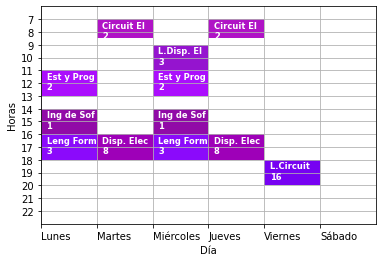

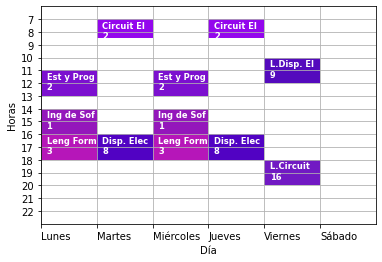

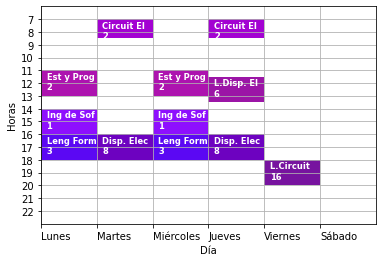

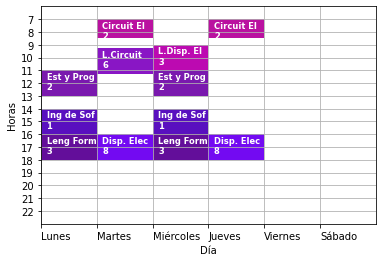

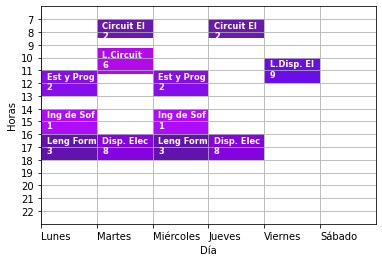

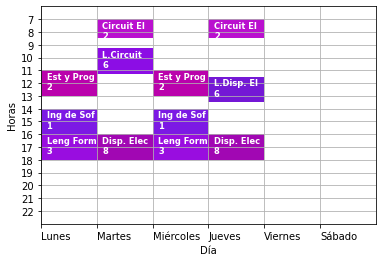

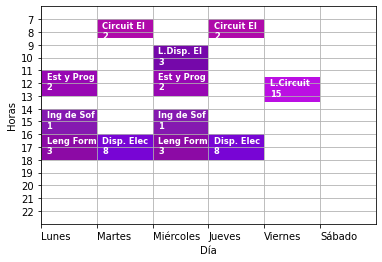

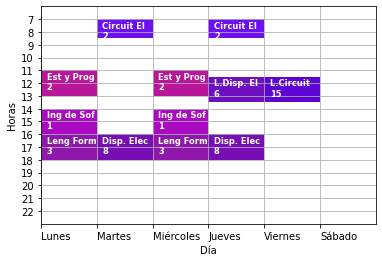

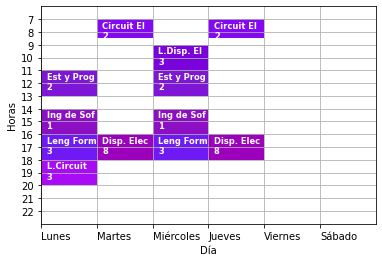

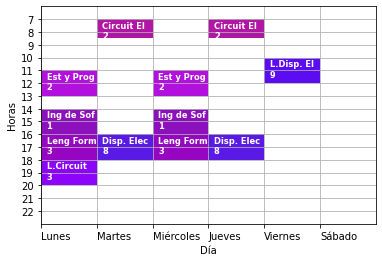

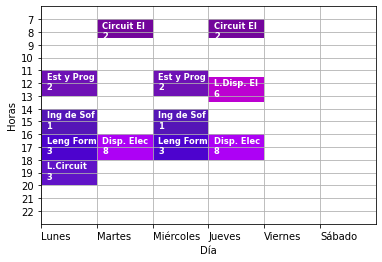

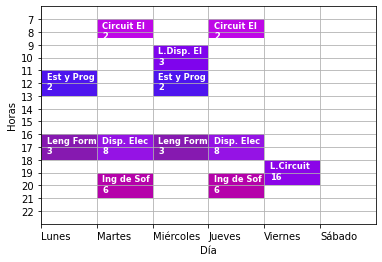

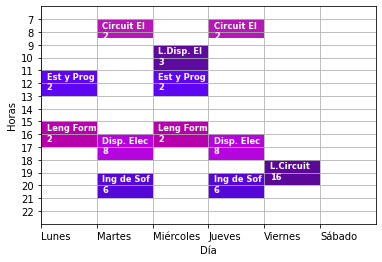

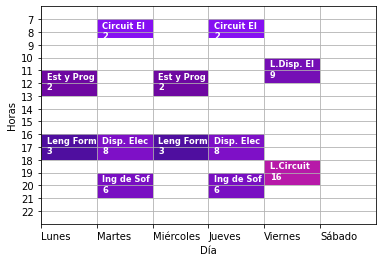

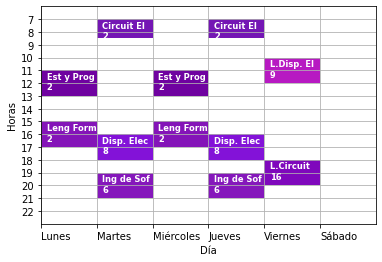

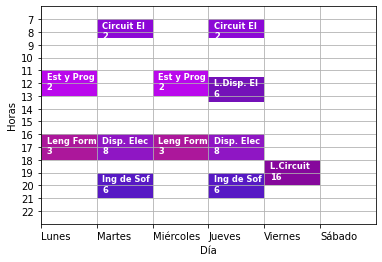

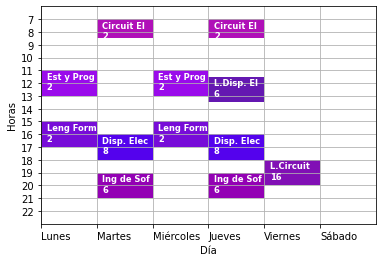

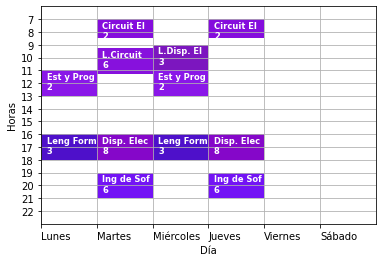

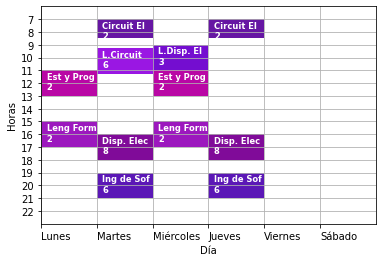

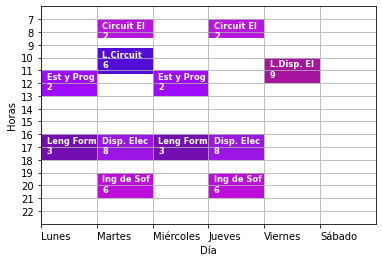

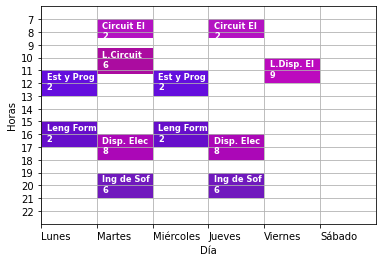

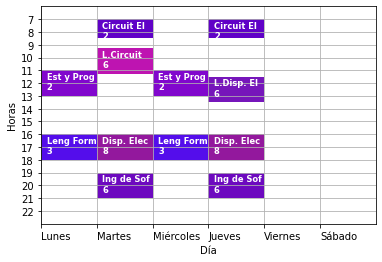

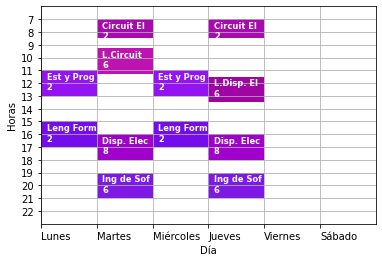

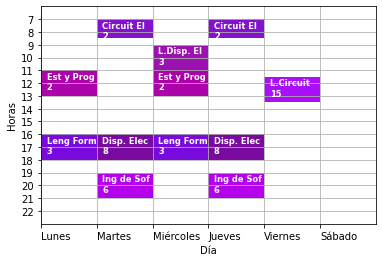

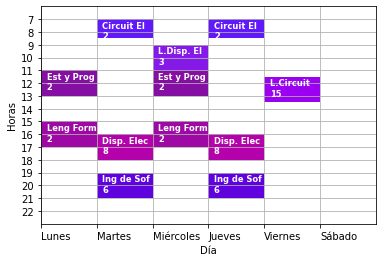

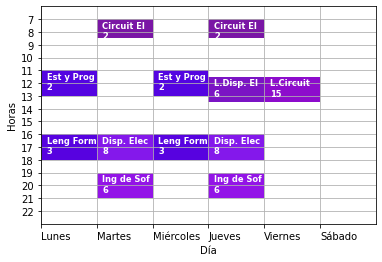

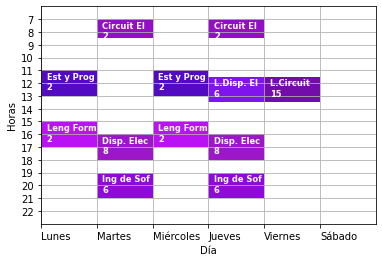

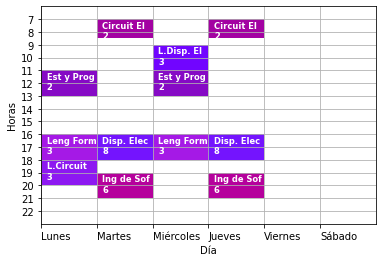

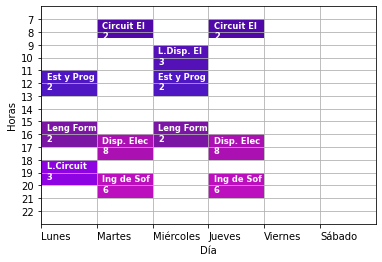

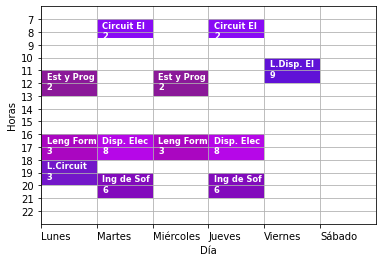

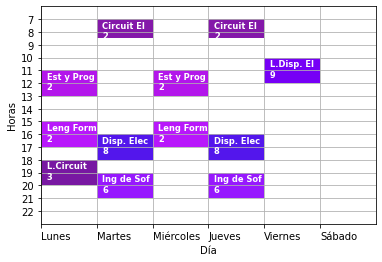

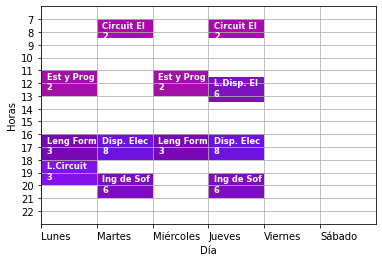

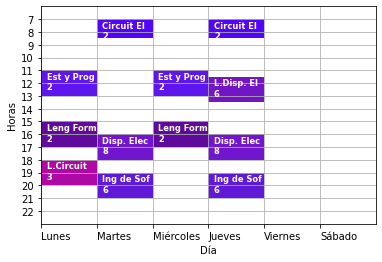

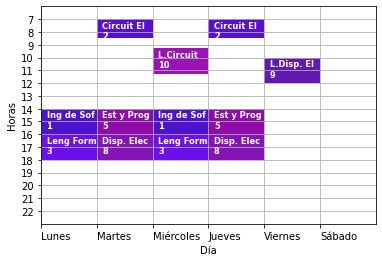

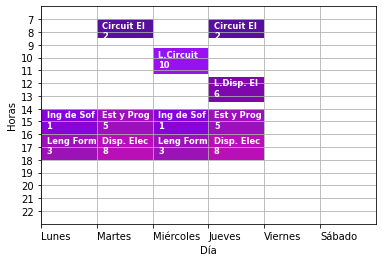

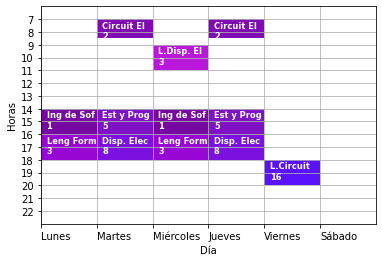

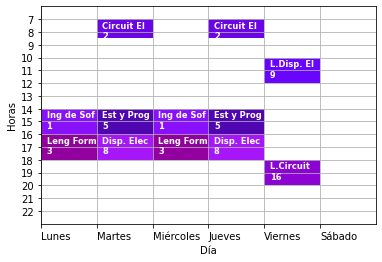

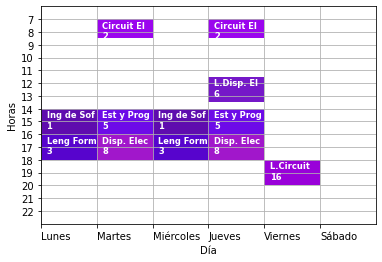

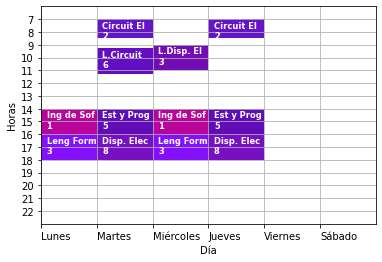

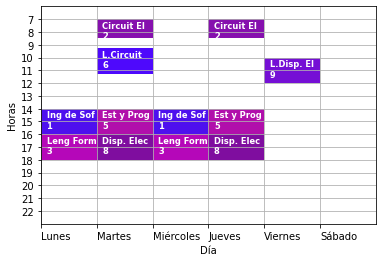

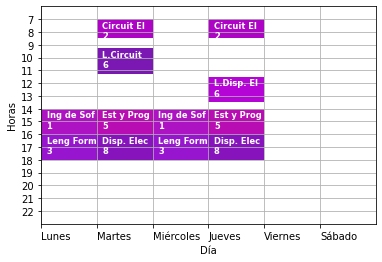

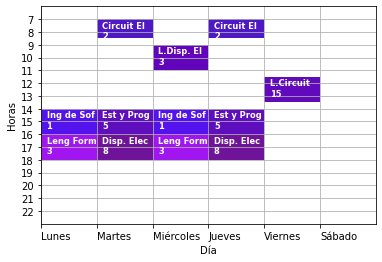

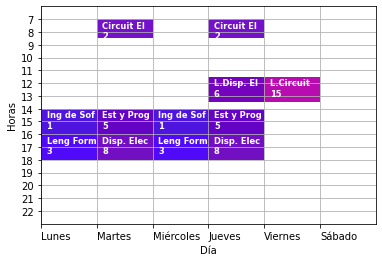

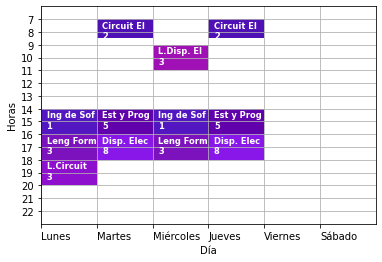

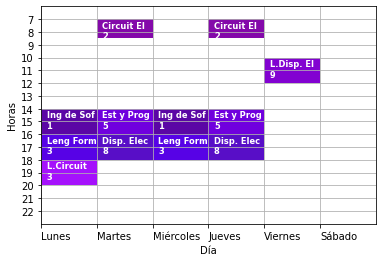

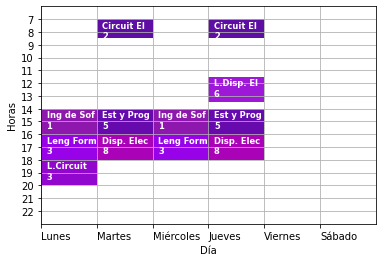

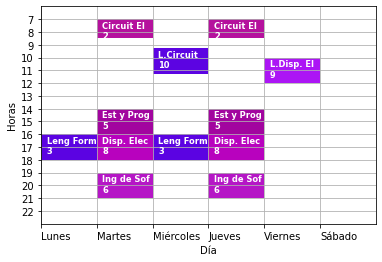

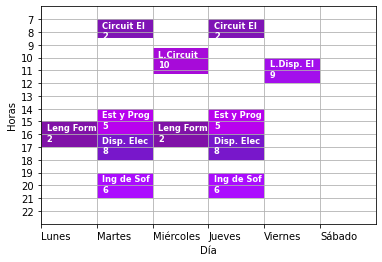

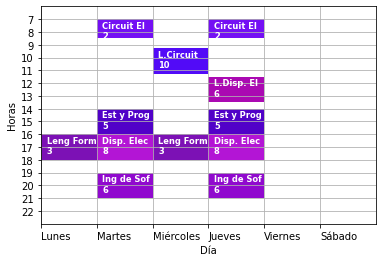

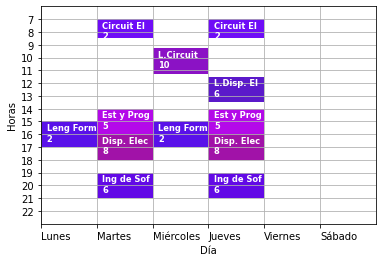

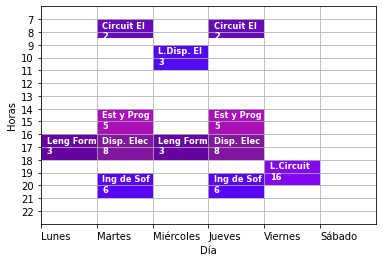

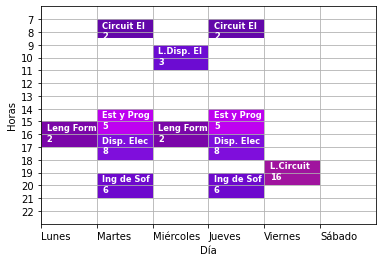

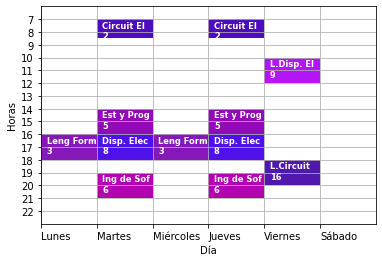

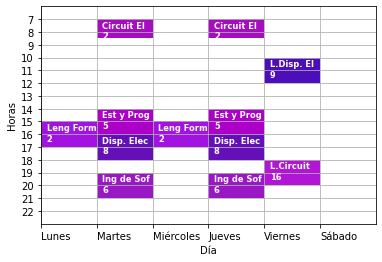

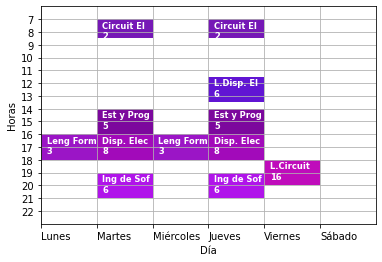

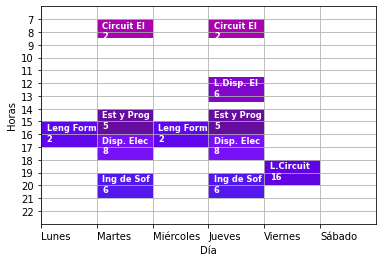

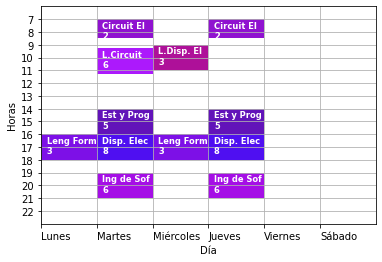

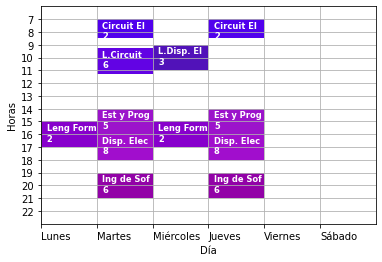

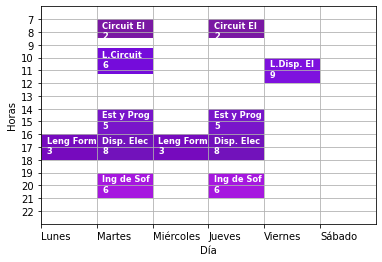

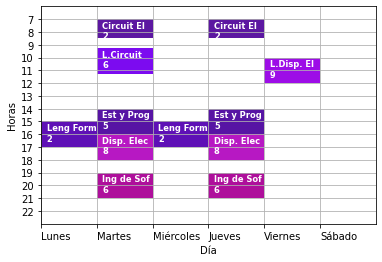

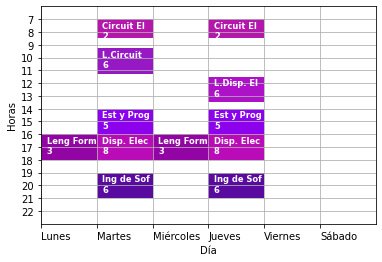

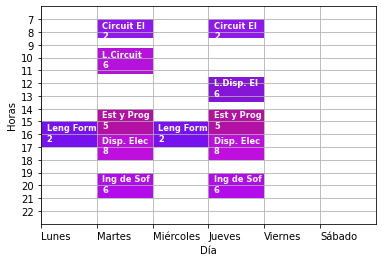

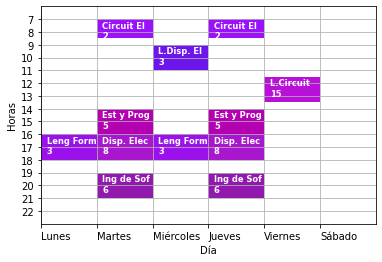

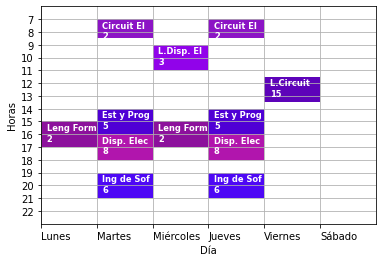

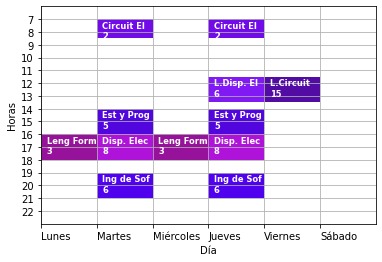

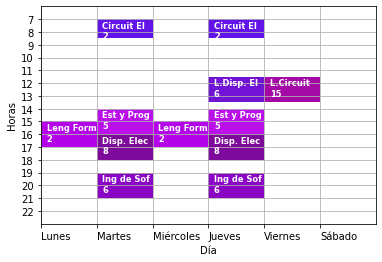

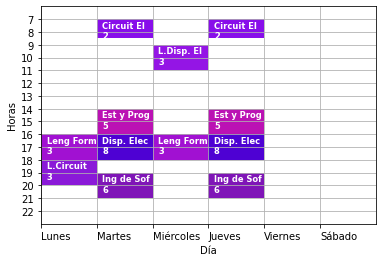

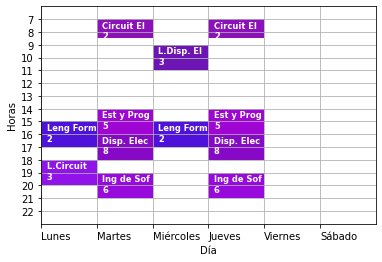

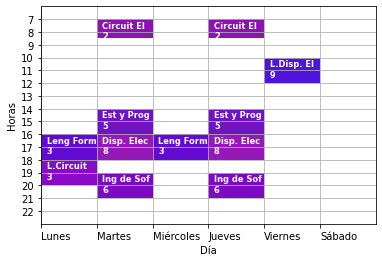

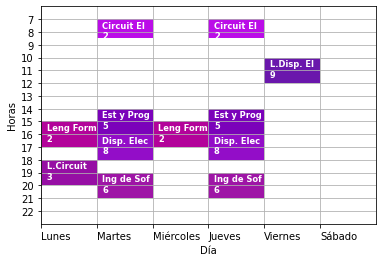

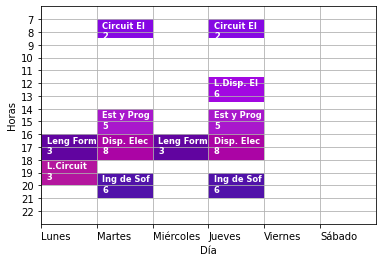

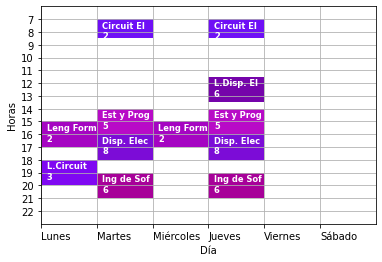

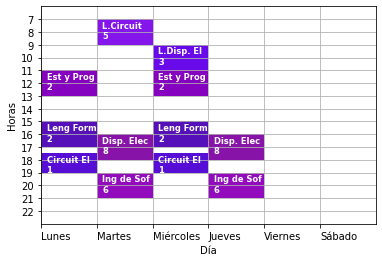

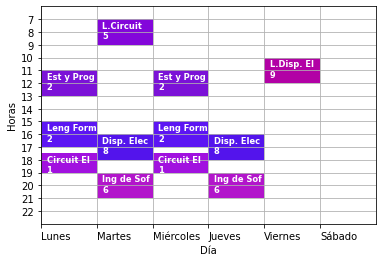

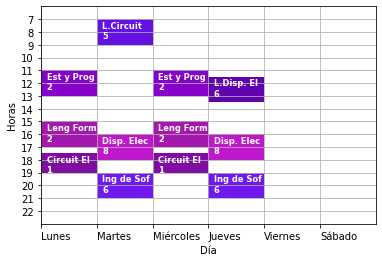

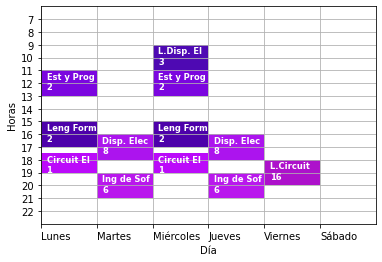

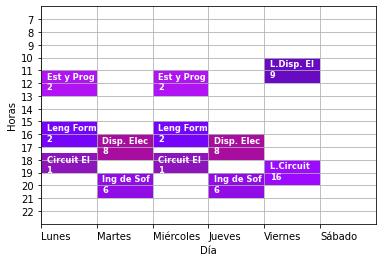

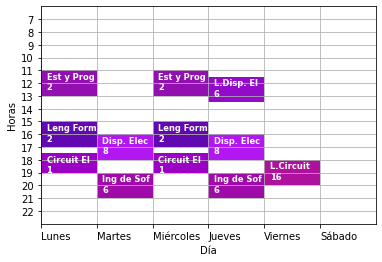

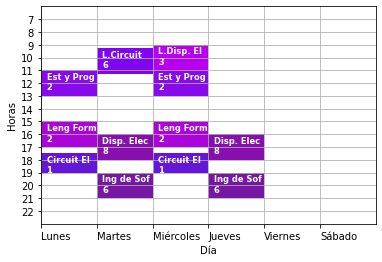

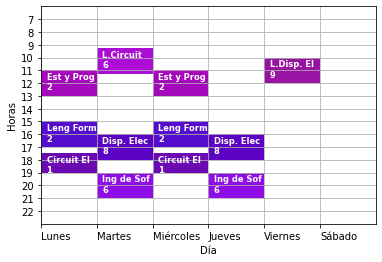

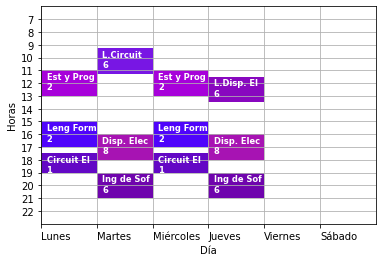

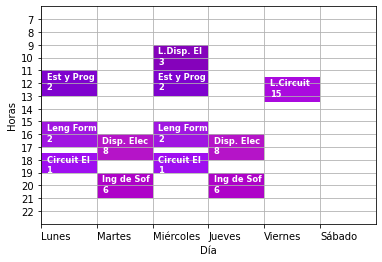

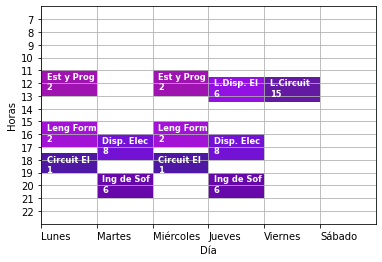

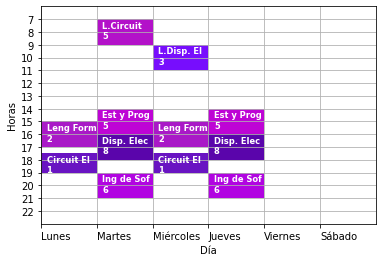

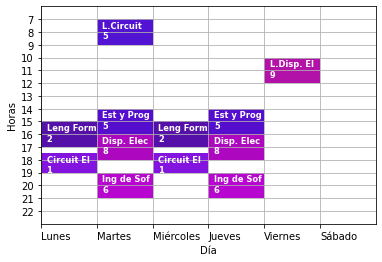

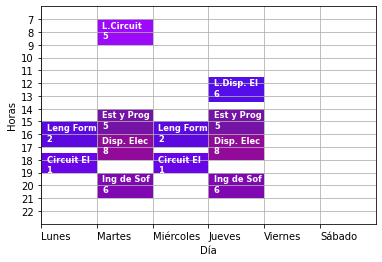

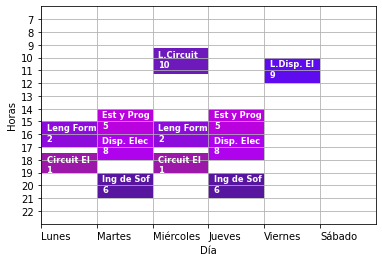

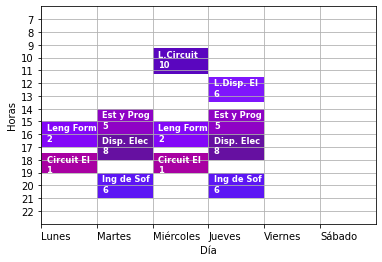

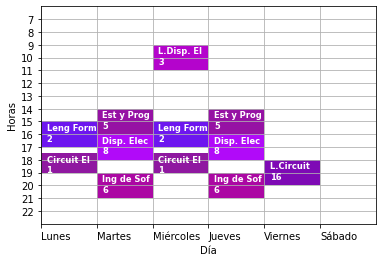

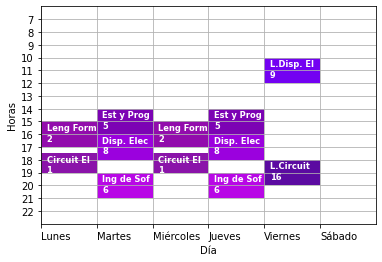

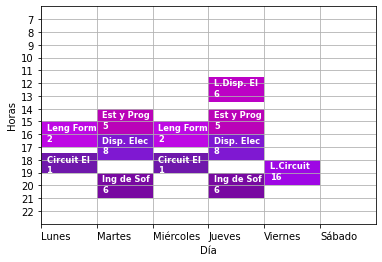

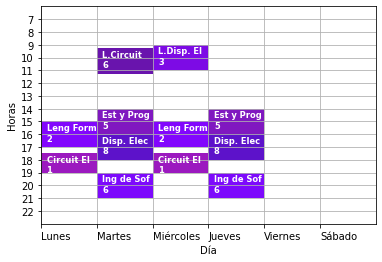

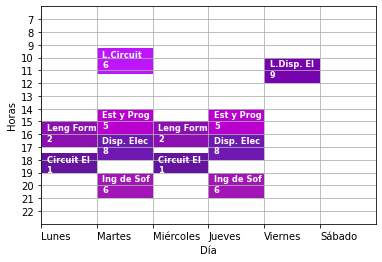

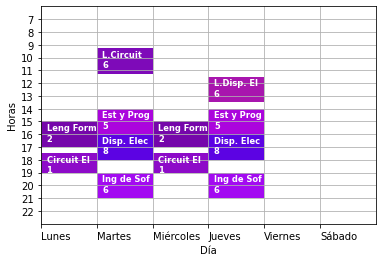

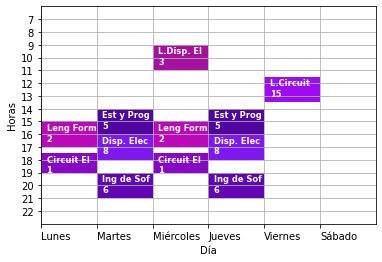

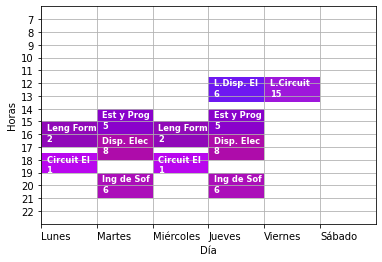

In [77]:
horario = pd.DataFrame(columns = df.columns)
horario
cero = pd.Series([0,0,0,0,0,0], index = orden).astype(object)
generarHorarios()
imprimirHorarios()


In [78]:
def imprimirHorarios():
    import os, shutil
    i = 1
    folder = 'Horarios'
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    for horario in lista_horarios: 
        plotHorario(horario,i)
        print(horario.iloc[:,0:8].drop(['Tipo','Cupo'],axis=1))
        horario.drop(horario.tail(1).index,inplace=True)
        i+=1